# EEG Dataset Processing Pipeline

Scope:
- Process a raw EEG dataset 
- Dataset containing the results of an EEG study on multiple subjects
- Dataset that has been downloaded from OpenNeuro, and structured as per the BIDS standard, and in EEGLab '.set' format

Parameters:
- Defined as part of the Study Class

The Pipeline Stages (For each subject in an EEG study dataset):
- EEG Dataset Load - Get the raw source EEG signal data
- EEG Preprocessing - Execute filtering etc of the raw EEG time series data
- Power Spectra (PSD) Calculate - Calculate the power spectra, for all channels recorded
- Spectral Parameterisation - Determine the best fitting Aperiodic and Periodic components
- Features Set - Collate & save the study, subject and EEG data into a features set, Pandas Dataframe


## TO DO - To Review

Projects:
- Perplexity project: https://www.perplexity.ai/search/i-am-building-a-pipeline-in-py-sVmw70rHQXa0VKkIT_p5tg?0=r
- Python Handbook: https://github.com/ZitongLu1996/Python-EEG-Handbook/tree/master

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- specparam = 2.0.0rc3

## Python-MNE

Used for Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io

EEG Data Format for Processing:
- In FIF format (Functional Image File Format): https://www.perplexity.ai/search/having-read-some-eeg-data-usin-70hxIA1KSZu6VdV.MfLY_A

Used for Power Spectrum Calculate
- MNE vs NeuroDSP: https://www.perplexity.ai/search/using-python-which-package-is-zOoiPqUvTnKbO.QfgmPsJQ

Formats:
- Assumes OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure
- Assumes EEGLab '.set' format


## Spectral Parameterisation

Spectral Parameterisation:
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Documentation:
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools
- FOOOF: https://fooof-tools.github.io/fooof/ and https://github.com/fooof-tools/fooof

FOOOF vs SpecPram:
- FOOOF: More stable and used but deprecated
- SpecParam: Release candidate but some improved model/fit selection: https://pmc.ncbi.nlm.nih.gov/articles/PMC11326208/
- Summary: https://www.perplexity.ai/search/using-python-which-package-is-M7kzhERoTLuCrIKbXxN9sQ


# Imports & Utilities

In [1]:
# Not availble through a Conda install/environment - PIP Install may be required
# %pip install specparam


In [2]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle

import math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# MNE-Python
import mne

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra

# Check the version of SpecParam
from specparam import __version__ as specparam_version
print('Current SpecParam version:', specparam_version)


Current SpecParam version: 2.0.0rc3


In [3]:
# Utility function to establish relative paths for a given folder
def get_folder_path(folder_name, data_folder='Data'):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
    return folder_path

# Utility function to create a new folder path, if not exists
def make_folder_path(folder_name, data_folder='Data', exists_ok=True):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if os.path.exists(folder_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {folder_path}")
    else:
        os.makedirs(folder_path)
    return folder_path

 # Utility function to extend an existing folder path with a subfolder
def extend_folder_path(base_folder, subfolder, exists_ok=True):
    if not os.path.isdir(base_folder):
        raise FileNotFoundError(f'Parent directory not found: {base_folder}')
    extended_path = os.path.join(base_folder, subfolder)
    if os.path.exists(extended_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {extended_path}")
    else:
        os.makedirs(extended_path)
    return extended_path

# Utility function to check for the existence of a file in a given folder
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

## EEG_Study Class

In [4]:
# Class defining the paraemters for an EEG study

class EEG_Study:
    """
    Defintion and parameters for an EEG study

    Attributes
    ----------
    study_run_id : str
    subjects_df : dataframe of subjects in study
    psd_params : parameters for power spectra / PSD calculation
    specparam_params : parameters for SpecParam
    """

    # Data Folders
    __eeg_datasets_source_folder = 'EEG_Datasets_Source_exgithub'
    __1_EEG_Processing_Results = '1_EEG_Processing_Results'
    __2_ML_Training_Results = '2_ML_Training_Results'

    # BIDS structure, file name for source of subjects data
    __subjects_source_file = 'participants.tsv'

    # Execution Parameters
    __psd_params = {'method': 'welch', # Calculation method
                    'fmin': 1,         
                    'fmax': 250,       
                    'exclude': []      # Includes all, even bad channels
                    }
    __specparam_params = {'peak_width_limits': [1, 12],
                        'max_n_peaks': 10,
                        'min_peak_height': 0.1,
                        'peak_threshold': 2.0,
                        'aperiodic_mode': 'fixed',
                        'fit_freq_range' : [1, 75]
                        }

    def __init__(self, study_name , dataset_ref):
        """
        Initialise EEG_Study instance.

        Parameters
        ----------
        study_name : str
        dataset_ref : str

        Returns
        -------
        Study : class instance
        """

        # Create id for the study run
        current_date = datetime.now().strftime('%Y%m%d')
        study_run_id = f'{dataset_ref}_{current_date}'

        # Establish Folder Structure for the Study
        eeg_datasets_folder_path = get_folder_path(self.__eeg_datasets_source_folder)
        eeg_processing_results_path = make_folder_path('Study_' + study_name + '/' + self.__1_EEG_Processing_Results + '_' + study_run_id)
        ml_training_results_path = make_folder_path('Study_' + study_name + '/' + self.__2_ML_Training_Results + '_' + study_run_id)

        # Validation - Valid Dataset
        datasets_list = os.listdir(eeg_datasets_folder_path)
        datasets_list = [d for d in datasets_list if d.startswith('ds') and os.path.isdir(os.path.join(eeg_datasets_folder_path, d))]
        if dataset_ref not in datasets_list:
            raise ValueError(f"Dataset '{dataset_ref}' not found in list of available datasets: {datasets_list}")
        dataset_path = os.path.join(eeg_datasets_folder_path, dataset_ref)
        if not os.path.exists(dataset_path):
            raise FileNotFoundError(f"Path does not exist: {dataset_path}")
        
        # Validation - Subjects File
        subjects_file = os.path.join(eeg_datasets_folder_path, dataset_ref, self.__subjects_source_file)
        if not os.path.isfile(subjects_file):
            raise FileNotFoundError(f'File not found: {subjects_file}')
        # subjects_df = self._create_subjects_df(subjects_file)
        
        # Private Attributes
        # TODO: Any private attributes?

        # Public Attributes
        self.study_name = study_name
        self.study_run_id = study_run_id
        self.subjects_file = subjects_file
        self.dataset_path = dataset_path
        self.results_folder_path = eeg_processing_results_path
        self.psd_params = self.__psd_params
        self.specparam_params = self.__specparam_params

    # Private functions

    # Public functions

    def create_subjects_df(self):
        # Read the datset csv file to get selected subjects data
        try:
            temp_subjects_df = pd.read_csv(self.subjects_file, sep='\t')
        except Exception as e:
            raise IOError(f"Failed to read subjects file '{self.subjects_file}': {e}")

        # Cater for different format participants.tsv file
        possible_column_names = [
                    (['participant_id', 'GROUP', 'AGE', 'GENDER'], ['subject_id', 'pd', 'age', 'gender']),
                    (['participant_id', 'Group', 'age', 'sex'], ['subject_id', 'pd', 'age', 'gender'])
                ]
        for cols, new_cols in possible_column_names:
            try:
                subjects_df = temp_subjects_df[cols].copy()
                subjects_df.columns = new_cols
                break
            except KeyError:
                continue
        else:
            raise KeyError("Required columns in subjects file. Found: "f"{temp_subjects_df.columns.tolist()}")
        
        # Map 'pd', 'Control', 'cTL' to 1, 0, 0 respectively in 'pd' column
        mapping = {'PD': 1, 'pd': 1, 'Control': 0, 'CTL': 0}
        if not subjects_df['pd'].isin(mapping.keys()).all():
            invalid_vals = subjects_df.loc[~subjects_df['pd'].isin(mapping.keys()), 'pd'].unique()
            raise ValueError(f"Invalid values in 'pd' column: {invalid_vals}")
        subjects_df['pd'] = subjects_df['pd'].map(mapping).astype(int)

        return subjects_df
    
    

## Get Raw EEG data

In [5]:
# Function to get the raw EEG signal data
def get_EEG_raw(dataset_path, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    dataset_path : str
    subject_id : str

    Returns
    -------
    EEG_raw : FIF
    """
    
    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # Cater for none or multiple sessions, eg 'ses-01', 'ses-02'
    temp_path = os.path.join(dataset_path, subject)
    subfolders = [f for f in os.listdir(temp_path) if os.path.isdir(os.path.join(temp_path, f))]
    if 'eeg' in subfolders:
        session = ''
    elif any(f.startswith('ses-') for f in subfolders):
        session = sorted([f for f in subfolders if f.startswith('ses-')])
    else:
        raise FileNotFoundError(f"No 'eeg' or session folder found in {temp_path}")
    
    # Cater for 0 or multiple sessions
    # print(f'Test Found: {session}')
    sessions_eeg_raw = []
    if session == '':
        temp_path = os.path.join(dataset_path, subject, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = get_file_path(temp_path, temp_file_name)
        try:
            eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)
            sessions_eeg_raw.append(eeg_dataset_raw)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    else:
        for next_session in session:
            temp_path = os.path.join(dataset_path, subject, next_session, datatype)
            temp_file_name = subject + '_' + next_session + '_task-' + task + '_' + datatype + '.set'
            eeg_lab_file_path = get_file_path(temp_path, temp_file_name)
            # print(f'Test session path: {eeg_lab_file_path}')
            try:
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)
                sessions_eeg_raw.append(eeg_dataset_raw)
            except Exception as e:
                raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    
    return sessions_eeg_raw

In [6]:
# Function to plot EEG Time Series
def plot_EEG_TD(eeg_FIF, channels, time_range_s=[]):
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    start = (time_range_s[0] * 500) if time_range_s else 0
    stop = (time_range_s[1] * 500) if time_range_s else 999999


    # Get signal and times for the elected channel(s)
    signal, times = eeg_FIF.get_data(picks=channels, 
                                     start=start, stop=stop,
                                     return_times=True)
    # signal = np.squeeze(signal)

    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## EEG Preprocessing

In [7]:
# Function to preprocess the raw EEG signal data
def perform_EEG_preprocessing(study, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    study : Study class
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    print(f'TO DO - Preprocess of raw EEG')

    # TODO: Add filtering
    # TODO: Add ICA
    # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING

    # if 'VERBOSE' in globals() and VERBOSE:
    #     print('To Do: Preprocessing results ....')

    EEG_clean = EEG_raw

    return EEG_clean


## Get the Power Spectra

In [8]:
# Function to get the power spectra from the cleaned/preprocessed EEG signal data
def get_spectra(study, EEG_clean):
    """
    Obtain the Power Spectra for all channels

    Parameters
    ----------
    study : Study class
    EEG_clean : clean

    Returns
    -------
    Spectra : frequencies and powers for each channel
    """
    try:
        spectra_result = EEG_clean.compute_psd(method=study.psd_params['method'],
                                               fmin=study.psd_params['fmin'],
                                               fmax=study.psd_params['fmax'],
                                               exclude=study.psd_params['exclude'])
    except Exception as e:
        raise Exception(f"Error calculating spectra: {e}")

    return spectra_result


In [9]:
# Function to plot EEG Frequncy Domain / PSD
def plot_EEG_PSD(spectra, channel):
    """
    EEG Frequency Domain / PSD Plot.

    Parameters
    ----------
    spectra : mne.Spectrum
    channel : str eg 'P5'
    """

    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    print('Quick PSD')
    spectra.plot()
    plt.show()

    # Log-log plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
        plt.loglog(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Log) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # Log-lin plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
         plt.semilogy(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Lin) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # A selected channel
    ch_label = channel
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(f'Power Spectrum - Channel {ch_label} ({spectra.method} method)', fontsize=20)
    ax0.set_title('Log/Log')
    ax1.set_title('Log/Lin')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')
    plt.show()


## Spectral Parameterisation

In [10]:
# Function to perform Spectral Parameterisation and dtermine the aperiodic and periodic components
def perform_SpecParam(study, spectra):
    """
    Spectral Parameterisation to determine the aperiodic and periodic components for all channels

    Parameters
    ----------
    study : Study class
    spectra : spectra

    Returns
    -------
    specparam_df : dataframe of components for each channel
    fg : SpectralGroup Model

    """

    # Initialise SpecParam Group Model & fit it
    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    spm_fit_freq_range = [1, 75]

    try:
        fg = SpectralGroupModel(peak_width_limits=study.specparam_params['peak_width_limits'], 
                                max_n_peaks=study.specparam_params['max_n_peaks'], 
                                min_peak_height=study.specparam_params['min_peak_height'],
                                peak_threshold=study.specparam_params['peak_threshold'],
                                aperiodic_mode=study.specparam_params['aperiodic_mode'])
        fg.fit(freqs, powers, study.specparam_params['fit_freq_range'], progress='tqdm.notebook')
    except Exception as e:
        raise Exception(f"Error performing SpecParam: {e}")

    specparam_df = fg.to_df(study.specparam_params['max_n_peaks'])        
    
    return specparam_df, fg


In [11]:
# Function to plot SpecParam Results
def plot_SpecParam(fg, channel_indx, channel_name):
    """
    EEG SpecParam Results Plot

    Parameters
    ----------
    fg : SpecParamGroupModel
    """
    fm = fg.get_model(ind=channel_indx, regenerate=True)
    fm.print_results()

    # fm.plot()
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    fig.suptitle(f'Spec Param for Channel: {channel_name}', fontsize=20)
    ax0.set_title('Components - Log/Lin')
    ax1.set_title('Components - Log/Log')
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
    plt.show()


# Execute Full EEG Pipeline - Single Dataset

In [13]:
# EEG Pipeline Run Define & Setup
#

# Study Details
# study_name = 'IOWA_Rest'
# dataset_ref = 'ds004584-1.0.0'
study_name = 'UNM_Oddball'
dataset_ref = 'ds003490-1.1.0'

# Run/Test Mode
test_mode = True

# Execution Parameters
preprocess_params = {'filtering': 'none'
                     }
psd_params = {'method': 'welch', # Calculation method
              'fmin': 1,         
              'fmax': 250,       
              'exclude': []  # Includes all, even bad channels
              }
specparam_params = {'peak_width_limits': [1, 12],
                    'max_n_peaks': 10,
                    'min_peak_height': 0.1,
                    'peak_threshold': 2.0,
                    'aperiodic_mode': 'fixed',
                    'fit_freq_range' : [1, 75]
                     }


# ----------------------------------------
# Get existing study details, if exists
study_folder_path = get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
dataset_path = study_info_df.loc[0, 'dataset_path']
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Establish a new EEG Processing Run
current_date = datetime.now().strftime('%Y%m%d')
eeg_run_id = f'EEG_Processing_{dataset_ref}_{current_date}'
eeg_processing_run_path = extend_folder_path(eeg_processing_results_path, eeg_run_id, exists_ok=False)

# Create run df  save
eeg_run_params_df = pd.DataFrame({
    'eeg_run_id': [eeg_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'preprocess_params': [preprocess_params],
    'psd_params': [psd_params],
    'specparam_params': [specparam_params],
})
eeg_run_params_df.to_pickle(eeg_processing_run_path + '/eeg_run_params_df.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    max_subjects_run = 2
    test_channels = ['P5', 'C4', 'Cz']
else:
    VERBOSE = False
    max_subjects_run = np.inf
    test_channels = []

del current_date, eeg_processing_results_path


-----------------------------------------------------------------------------------------------
Processing subject: sub-001

--Get EEG Raw Data - FIT-----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds003490-1.1.0/sub-001/ses-01/eeg/sub-001_ses-01_task-Rest_eeg.fdt
Reading 0 ... 294099  =      0.000 ...   588.198 secs...
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds003490-1.1.0/sub-001/ses-02/eeg/sub-001_ses-02_task-Rest_eeg.fdt
Reading 0 ... 272524  =      0.000 ...   545.048 secs...


/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_13035/1578198718.py:53: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)
/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_13035/1578198718.py:53: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)


Description: None on None
<RawEEGLAB | sub-001_ses-01_task-Rest_eeg.fdt, 67 x 294100 (588.2 s), ~150.4 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 67 EEG
 custom_ref_applied: False
 dig: 67 items (67 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 500.0 Hz
>


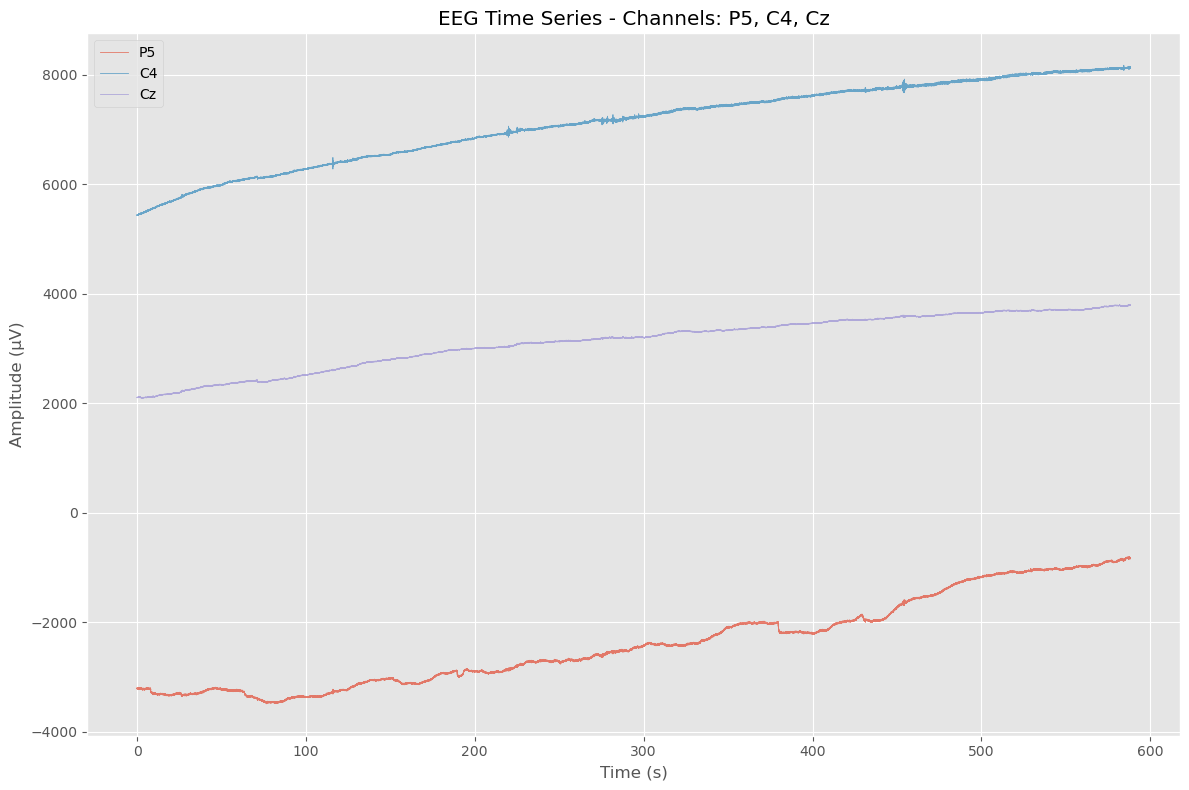


-----------------------------------------------------------------------------------------------
Processing subject: sub-002

--Get EEG Raw Data - FIT-----------------------------------------
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds003490-1.1.0/sub-002/ses-01/eeg/sub-002_ses-01_task-Rest_eeg.fdt
Reading 0 ... 319524  =      0.000 ...   639.048 secs...
Reading /Users/stuartgow/GitHub/EEG_ML_Pipeline/Data/EEG_Datasets_Source_exgithub/ds003490-1.1.0/sub-002/ses-02/eeg/sub-002_ses-02_task-Rest_eeg.fdt
Reading 0 ... 280724  =      0.000 ...   561.448 secs...


/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_13035/1578198718.py:53: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)
/var/folders/wd/rhzj_w8570g_y66t6j6mh4zw0000gn/T/ipykernel_13035/1578198718.py:53: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True)


Description: None on None
<RawEEGLAB | sub-002_ses-01_task-Rest_eeg.fdt, 67 x 319525 (639.0 s), ~163.4 MiB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 67 EEG
 custom_ref_applied: False
 dig: 67 items (67 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 67
 projs: []
 sfreq: 500.0 Hz
>


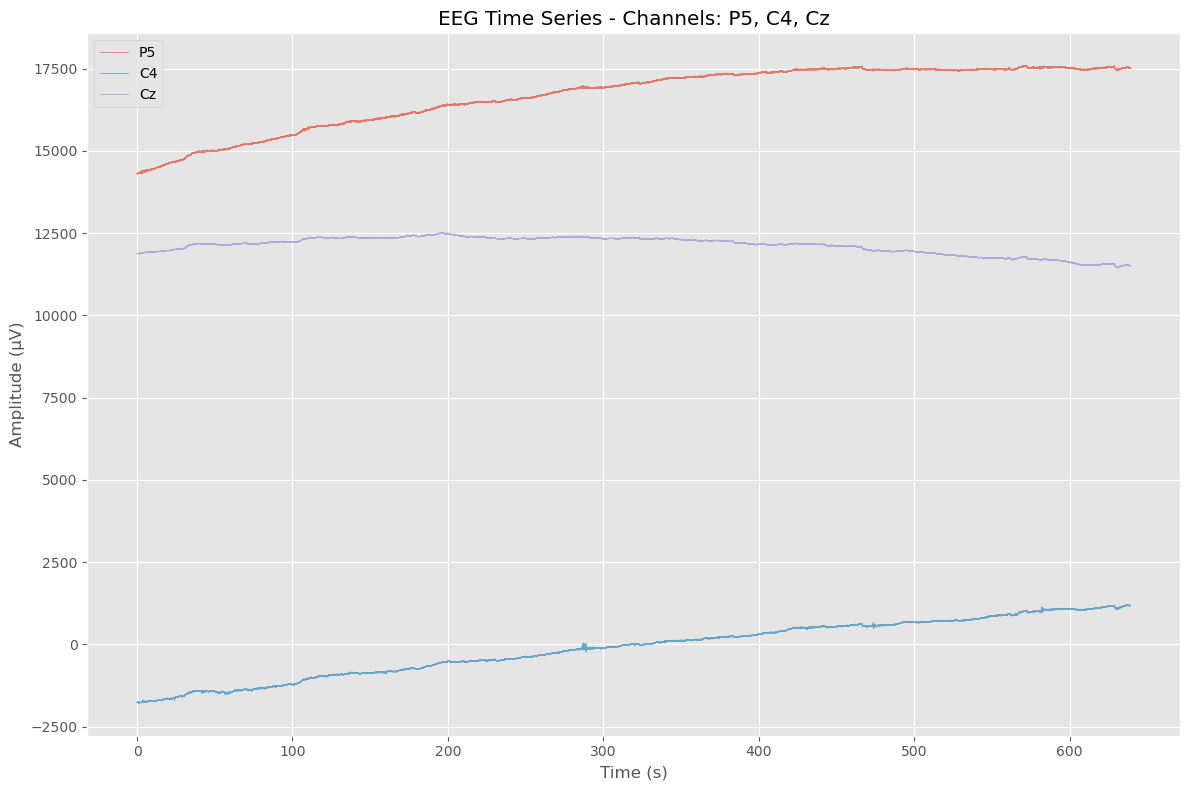

In [14]:
# Execute the pipeline for each subject
#

for idx, subject in study_subjects_df.iterrows():
    # Break for testing
    if int(idx) > (max_subjects_run - 1):
        break

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Processing subject: {subject_id}")

    # Get the raw EEG data
    if VERBOSE:
        print('\n--Get EEG Raw Data - FIT-----------------------------------------')
    temp_EEG_raw_files = get_EEG_raw(dataset_path, subject_id)
    # TODO: How to handle multiple session EEG raw files?
    temp_EEG_raw = temp_EEG_raw_files[0]
    if VERBOSE:
        print(f"Description: {temp_EEG_raw.info['description']} on {temp_EEG_raw.info['meas_date']}")
        print(temp_EEG_raw)
        print(temp_EEG_raw.info)

        plot_EEG_TD(temp_EEG_raw, test_channels)






del idx, subject

xxxxxx

In [ ]:
# Execute the pipeline
#

# # Study Details & Run Mode
# study_name = 'IOWA_Rest'
# dataset_ref = 'ds004584-1.0.0'
# # study_name = 'UNM_Oddball'
# # dataset_ref = 'ds003490-1.1.0'
# test_mode = False

# # Datset
# # dataset_for_processing = 'ds004584-1.0.0'

# # Set progress messages, testing
# if test_mode:
#     VERBOSE = True
#     max_subjects_run = 2
#     test_channels = ['P5', 'C4', 'Cz']
# else:
#     VERBOSE = False
#     max_subjects_run = np.inf
#     test_channels = []

# # Establish the study details and initialise results dataframes
# study_params = EEG_Study(study_name, dataset_ref)

# # Establish dataframes to save results once completed
# study_params_df = pd.DataFrame({ 'study_name': [study_params.study_name],
#                                  'study_run_id': [study_params.study_run_id],
#                                  'dataset_path': [study_params.dataset_path],
#                                  'results_path': [study_params.results_folder_path],
#                                  'psd_params': [study_params.psd_params],
#                                  'specparam_params': [study_params.specparam_params]
#                                 #  'subjects_df': [study_params.subjects_df]
#                                  })
# study_subjects_df = study_params.create_subjects_df()
# study_features_df = pd.DataFrame()

# Run the pipeline for each subject in the study
for idx, subject in study_subjects_df.iterrows():
    # Break for testing
    if int(idx) > (max_subjects_run - 1):
        break

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Processing subject: {subject_id}")

    # Get the raw EEG data
    if VERBOSE:
        print('\n--Get EEG Raw Data - FIT-----------------------------------------')
    
    temp_EEG_raw_files = get_EEG_raw(study_params, subject_id)
    # TODO: How to handle multiple session EEG raw files?
    temp_EEG_raw = temp_EEG_raw_files[0]

    if VERBOSE:
        print(f"Description: {temp_EEG_raw.info['description']} on {temp_EEG_raw.info['meas_date']}")
        print(temp_EEG_raw)
        print(temp_EEG_raw.info)

        plot_EEG_TD(temp_EEG_raw, test_channels)

    # EEG Preprocessing
    if VERBOSE:
        print('\n--Preprocessing EEG----------------------------------------------')
    temp_EEG_clean = perform_EEG_preprocessing(study_params, temp_EEG_raw)    

    # Power spectrum
    if VERBOSE:
        print('\n--EEG Power Spectra----------------------------------------------')
    temp_spectra = get_spectra(study_params, temp_EEG_clean)
    if VERBOSE:
        print(f'Using parameters: {study_params.psd_params}')
        print(temp_spectra)
        print(temp_spectra.info)

        plot_EEG_PSD(temp_spectra, test_channels[0])

    # Spectral Parameterisation
    if VERBOSE:
        print('\n--EEG Spectral Parameterisation------------------------------------')
    specparam_df, fg = perform_SpecParam(study_params, temp_spectra)
    if VERBOSE:
        print(f'With parameters: {study_params.specparam_params}')
        print(f'Executed Settings: {fg.get_settings()}')

        # TODO: Assess the goodness of fit etc? Judge the quality of the fit?
        # TODO: Automatically remove any 'bad' results?
        # TODO: Some fits had more thatn the expected channels, eg subject 66 had 68 channels. Action?

        # Overall group results
        fg.print_results()
        fg.plot()
        plt.show()

        channel_idx = temp_spectra.ch_names.index(test_channels[0])
        plot_SpecParam(fg, channel_idx, test_channels[0])

    # Study Features Collate
    print('\n--Collating Study Features ----------------------------------------')
    # Features df - Subject Details
    subject_details_df = pd.DataFrame()
    subject_details_df = pd.concat([subject_details_df, pd.DataFrame([subject])], ignore_index=True)
    # Features df - Add all channels into a single row
    rows = [subject_details_df]
    for idx, row in specparam_df.iterrows():
        row_df = pd.DataFrame([row.values], columns=[f'chn_{idx}_{col}' for col in row.index])
        rows.append(row_df)
    subject_features_df = pd.concat(rows, axis=1, ignore_index=False)

    # Add the subject's features to the overall study features dataframe
    study_features_df = pd.concat([study_features_df, subject_features_df], ignore_index=True)

# Save study and features df
study_params_df.to_pickle(f"{study_params.results_folder_path}/study_params_df.pkl")
study_subjects_df.to_pickle(f"{study_params.results_folder_path}/study_subjects_df.pkl")
study_features_df.to_pickle(f"{study_params.results_folder_path}/study_features_df.pkl")


# save_results(study_params_df, study_subjects_df, study_features_df)
print('\n--Processing finished & Features Saved---------------------------------------------------------')

# Clean Up
del idx, max_subjects_run, row, row_df, rows, specparam_df, specparam_version
del study_params, subject, subject_details_df, subject_features_df, subject_id, test_channels, VERBOSE
# del temp_EEG_raw, temp_EEG_clean, temp_spectra
# del study_details_df, study_features_df

# Inspections

In [ ]:
# Examine time domain

channels = ['P5', 'C5', 'C4', 'Cz']
time_range = [0,25]
plot_EEG_TD(temp_EEG_raw, channels, time_range)

In [ ]:
channel_idx = temp_spectra.ch_names.index('P5')
plot_SpecParam(fg, channel_idx, 'P5')